In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nbodykit.lab import *
from nbodykit import style, setup_logging
import matplotlib.pyplot as plt
plt.style.use(style.notebook)
import gc
import pandas as pd

In [2]:
import momentum as m
import importlib
importlib.reload(m)

<module 'momentum' from '/Raid6/1/TeamYZ/xiting/momentum/momentum.py'>

In [3]:
data_read = pd.read_csv('./Ne_Galaxy_Mstar10_1.csv')
print(data_read)

                X           Y          Z          Vx          Vy          Vz  \
0       43.718810   48.813640  147.59496   472.19620   450.85000  -260.74692   
1       45.442272   51.850200  146.41650  -209.05666  -735.88890   400.64172   
2       44.490760   49.091713  147.87057  2021.72950  1495.44020 -1797.08220   
3       43.820786   50.939400  147.71104   925.15040  -473.44547  -275.92593   
4       44.302578   49.630974  147.86949  -260.21463 -2221.62520  -563.64130   
...           ...         ...        ...         ...         ...         ...   
97008   10.228784  118.992710  192.99580   281.99225  -676.88495  -561.23157   
97009  176.708270  108.186970  186.70604   409.06686  -361.67800    75.95431   
97010   44.697636   47.188305  149.88548   417.30246  1285.93070  -102.50597   
97011   43.667706   73.888084  147.98112  -330.13977  -287.87842  -679.89390   
97012   45.803550   69.286766  145.47922  -578.08417   241.42065   357.62564   

               Nex          Ney        

In [4]:
type(data_read)

pandas.core.frame.DataFrame

In [5]:
cat = np.array(data_read)

In [6]:
print(cat)
print(cat[:,0])

[[4.37188100e+01 4.88136400e+01 1.47594960e+02 ... 4.15615666e+03
  4.15553122e+03 4.15856489e+03]
 [4.54422720e+01 5.18502000e+01 1.46416500e+02 ... 1.11525943e+03
  1.11678949e+03 1.11533792e+03]
 [4.44907600e+01 4.90917130e+01 1.47870570e+02 ... 3.96390222e+03
  3.73518528e+03 3.81527510e+03]
 ...
 [4.46976360e+01 4.71883050e+01 1.49885480e+02 ... 1.23355526e+01
  1.10227249e+02 1.10306912e+02]
 [4.36677060e+01 7.38880840e+01 1.47981120e+02 ... 4.00629735e+01
  8.06023411e+01 8.05995352e+01]
 [4.58035500e+01 6.92867660e+01 1.45479220e+02 ... 1.32344476e+01
  8.73655995e-02 1.28345734e+01]]
[43.71881  45.442272 44.49076  ... 44.697636 43.667706 45.80355 ]


In [7]:
struct_dtype = np.dtype([
    ('Pos', np.float32, 3),
    ('Vel', np.float32, 3),
    ('CentralMvir', np.float32),
])

In [8]:
shape = cat.shape[0]
print(shape)

97013


In [9]:
cat_struct = np.zeros(shape, dtype=struct_dtype)

In [10]:
cat_struct['Pos']

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)

In [11]:
cat_struct['Pos'][:,0] = cat[:,0]
cat_struct['Pos'][:,1] = cat[:,1]
cat_struct['Pos'][:,2] = cat[:,2]
cat_struct['Vel'][:,0] = cat[:,3]
cat_struct['Vel'][:,1] = cat[:,4]
cat_struct['Vel'][:,2] = cat[:,5]
cat_struct['CentralMvir'] = cat[:,6]

In [12]:
cat_nb = m.nb.source.catalog.ArrayCatalog(cat_struct)

In [13]:
#const
LOS=[1,0,0]
z_eff=0

#cos
cosmo = cosmology.Planck15
H=cosmo.efunc(z_eff)*100
a=1/(1+z_eff)
def RED(cat):
    line_of_sight_x=(1,0,0)
    cat['vel_x']=cat['Vel']*line_of_sight_x/(a*H)

    cat['RsdPos_x']=cat['Pos']+(cat['vel_x']*line_of_sight_x)
    cat['Vx'] = cat['Vel'][:,0]
    return cat

In [14]:
cat_RSD = RED(cat_nb)

In [15]:
def momentum_01(cat, gamma=None, cache=True):
    if 'weight' not in cat:
        #无权重
        cat['weight'] = 1
    if 'RsdPos_x' in cat:
        #有红移
        LOS=(1,0,0)
        cat['RsdPos_x'] = cat['RsdPos_x']%200
        momentum_mesh = cat.to_mesh(interlaced=True,compensated=True, Nmesh=512, BoxSize=200, window='tsc', position='RsdPos_x', value='Vx',weight='weight')
        mesh = cat.to_mesh(interlaced=True,compensated=True, Nmesh=512, BoxSize=200, window='tsc', position='RsdPos_x')
    # else:
    #     #无红移
    #     momentum_mesh = cat.to_mesh(interlaced=True,compensated=True, Nmesh=512, BoxSize=200, window='tsc', position='Pos', value='Vx',weight='weight')
    #     mesh = cat.to_mesh(interlaced=True,compensated=True, Nmesh=512, BoxSize=200, window='tsc', position='Pos')
    r01 = FFTPower(momentum_mesh, mode='1d', poles=[1], second=mesh, los=LOS)
    P01 = 2 * r01.poles['k'] * r01.poles['power_1'].imag
    #cache
    # if cache is not False: 
    #     cache_write(num=num, r01=r01, P01=P01, gamma=gamma)
    return r01, P01

def momentum_00(cat, gamma=None, cache=True):
    if 'weight' not in cat:
        #无权重
        cat['weight'] = 1
    if 'RsdPos_x' in cat:
        #有红移
        LOS=(1,0,0)
        cat['RsdPos_x'] = cat['RsdPos_x']%200
        # momentum_mesh = cat.to_mesh(interlaced=True,compensated=False, Nmesh=256, BoxSize=1000, window='tsc', position='RsdPos_x', value='Vx',weight='weight')
        mesh = cat.to_mesh(interlaced=True,compensated=True, Nmesh=512, BoxSize=200, window='tsc', position='RsdPos_x')
    else:
        #无红移
        # momentum_mesh = cat.to_mesh(interlaced=False,compensated=False, Nmesh=256, BoxSize=1000, window='tsc', position='Pos', value='Vx',weight='weight')
        mesh = cat.to_mesh(interlaced=True,compensated=True, Nmesh=512, BoxSize=200, window='tsc', position='Pos')
    r00 = FFTPower(mesh, mode='1d', los=[1,0,0])
    P00 = r00.power['power'].real - r00.attrs['shotnoise']
    #cache
    # if cache is not False: 
    #     cache_write(num=num, r01=r01, P01=P01, gamma=gamma)
    return r00, P00

In [16]:
r00, P00 = momentum_00(cat=cat_RSD)
r01, P01 = momentum_01(cat=cat_RSD)

/tmp/ipykernel_4043738/1872351724.py:31: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  mesh = cat.to_mesh(interlaced=True,compensated=True, Nmesh=512, BoxSize=200, window='tsc', position='RsdPos_x')
/tmp/ipykernel_4043738/1872351724.py:9: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  momentum_mesh = cat.to_mesh(interlaced=True,compensated=True, Nmesh=512, BoxSize=200, window='tsc', position='RsdPos_x', value='Vx',weight='weight')
/tmp/ipykernel_4043738/1872351724.py:10: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  mesh = cat.to_mesh(interlaced=True,compensated=True, Nmesh=512, BoxSize=200, window='tsc', position='RsdPos_x')


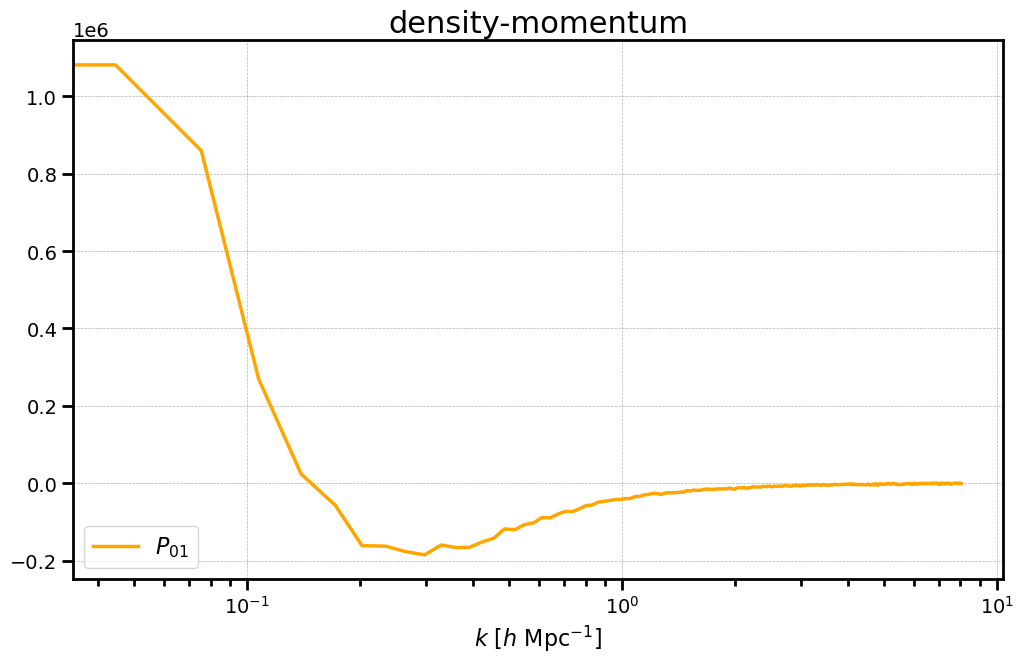

In [17]:
plt.loglog(r01.power['k'], P01, label=r"$P_{01}$", color='orange')
plt.title("density-momentum")
plt.legend(loc='lower left', ncol=2)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
# plt.ylabel(r"$P_{xy}$ [$h^{-3} \mathrm{Mpc}^3$]")
# plt.xlim(0.01, 0.6)
plt.yscale('linear')

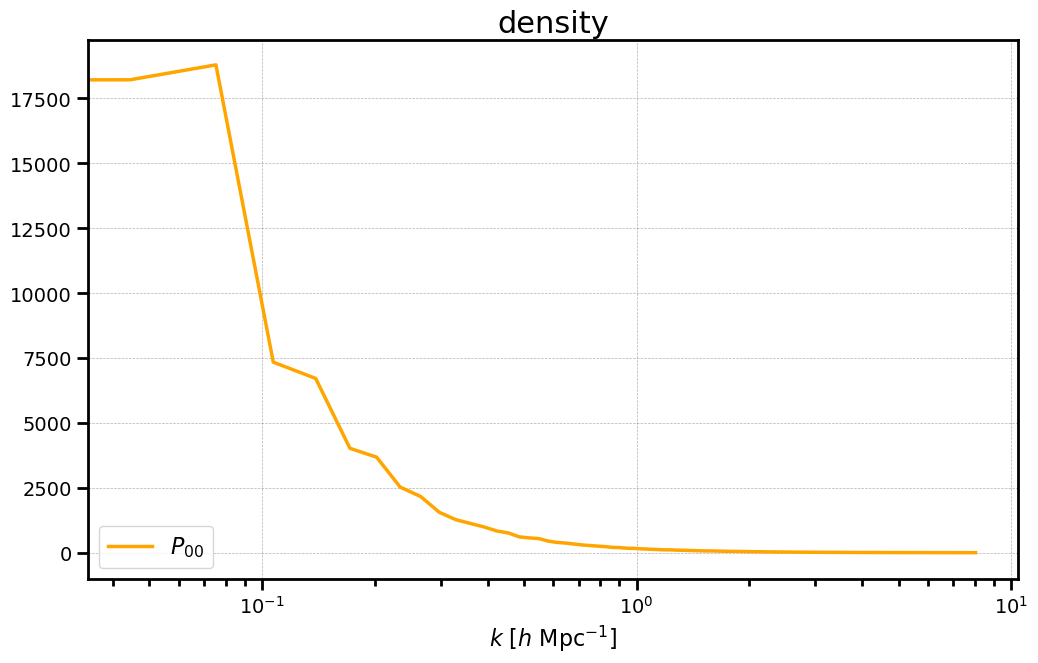

In [18]:
plt.loglog(r00.power['k'], P00, label=r"$P_{00}$", color='orange')
plt.title("density")
plt.legend(loc='lower left', ncol=2)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
# plt.ylabel(r"$P_{xy}$ [$h^{-3} \mathrm{Mpc}^3$]")
# plt.xlim(0.01, 0.6)
plt.yscale('linear')

In [19]:
r01_nw = r01
P01_nw = P01

/tmp/ipykernel_4043738/1872351724.py:9: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  momentum_mesh = cat.to_mesh(interlaced=True,compensated=True, Nmesh=512, BoxSize=200, window='tsc', position='RsdPos_x', value='Vx',weight='weight')
/tmp/ipykernel_4043738/1872351724.py:10: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  mesh = cat.to_mesh(interlaced=True,compensated=True, Nmesh=512, BoxSize=200, window='tsc', position='RsdPos_x')


Text(0.5, 1.0, 'rsd')

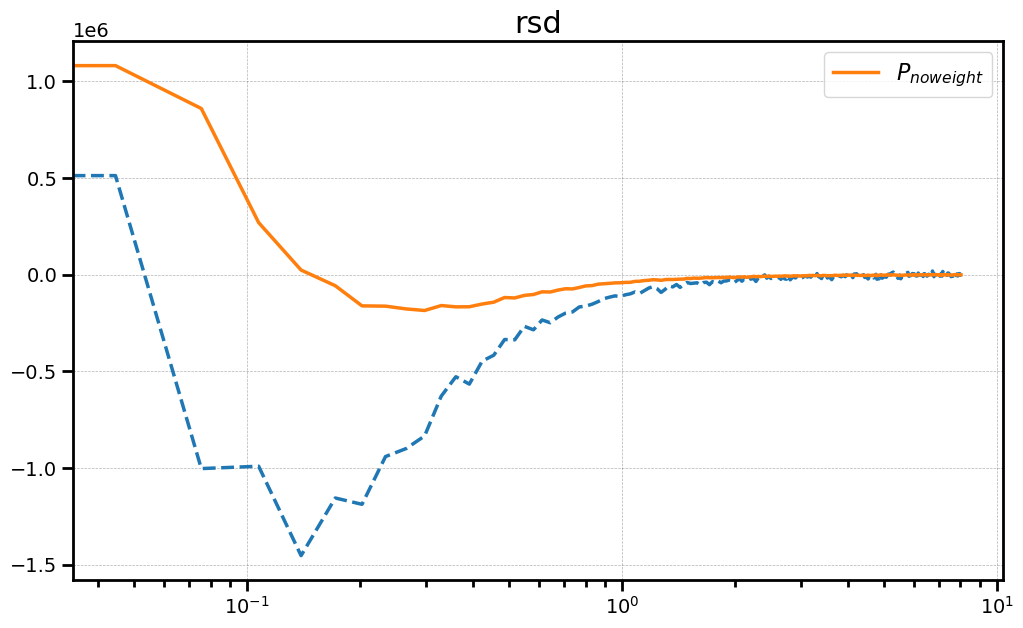

In [20]:

# for gamma in [0.6, 0.8, 1, 1.2, 1.4]:
#     label = r'$P_{%s}$' % (str(gamma))
#     #按gamma加权
#     cat_gamma = m.weight_gamma(cat=cat_RSD,gamma=gamma)
#     #计算矩阵
#     r01_gamma, P01_gamma = momentum_01(cat=cat_gamma, gamma=gamma)
#     plt.loglog(r01_gamma.power['k'], P01_gamma, label=label, linestyle='--')

cat_weight = m.weight(cat=cat_RSD)
r01_weight, P01_weight = momentum_01(cat=cat_weight)
plt.loglog(r01_weight.power['k'], P01_weight, linestyle='--')

plt.loglog(r01_nw.power['k'], P01_nw, label=r"$P_{noweight}$")
plt.yscale('linear')
plt.legend()
plt.title( 'rsd')


In [21]:
print(H)

100.0


In [64]:
def momentum_01_nw(cat, gamma=None, cache=True):
    LOS=(1,0,0)
    cat['RsdPos_x'] = cat['RsdPos_x']%200
    momentum_mesh = cat.to_mesh(interlaced=True,compensated=True, Nmesh=512, BoxSize=200, window='tsc', position='RsdPos_x', value='Vx')
    mesh = cat.to_mesh(interlaced=True,compensated=True, Nmesh=512, BoxSize=200, window='tsc', position='RsdPos_x')
    r01 = FFTPower(momentum_mesh, mode='1d', poles=[1], second=mesh, los=LOS)
    P01 = 2 * r01.poles['k'] * r01.poles['power_1'].imag
    return r01, P01
def RED_weight(cat):
    line_of_sight_x=(1,0,0)
    cat['vel_x']=cat['Vel']*line_of_sight_x/(a*H)
    cat['RsdPos_x']=cat['Pos']+(cat['vel_x']*line_of_sight_x)
    cat['Vx_1'] = cat['Vel'][:,0]
    # total_mvir = cat['CentralMvir'].compute().sum()
   #  mean_mvir = cat['CentralMvir'].compute().mean()
   #  central_mvir_values = cat['CentralMvir'].compute()
   #  # weights = central_mvir_values / (total_mvir/83492032)
   #  weights = central_mvir_values / mean_mvir
   #  # cat['weight'] = 1
   #  Vx = cat['Vx_1'].compute()
   # #  for i, weight in enumerate(weights):
   # #     Vx[i] = cat['Vx_1'][i] * weight
    cat['Vx']=cat['Vx_1']*(cat['CentralMvir']/cat['CentralMvir'].mean())
    
   #  cat['Vx'] = Vx
    cat['weight'] = 1
    return cat

In [65]:
cat_RW = RED_weight(cat_nb)
r01_rw, P01_rw = momentum_01_nw(cat=cat_RW)

/tmp/ipykernel_4043738/372192686.py:4: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  momentum_mesh = cat.to_mesh(interlaced=True,compensated=True, Nmesh=512, BoxSize=200, window='tsc', position='RsdPos_x', value='Vx')
/tmp/ipykernel_4043738/372192686.py:5: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  mesh = cat.to_mesh(interlaced=True,compensated=True, Nmesh=512, BoxSize=200, window='tsc', position='RsdPos_x')


In [66]:
print(np.array(cat_RW['Vx'][:3]))
print(np.array(cat_RW['CentralMvir']/cat_RW['CentralMvir'].mean()))
print(np.array(cat_RW['RsdPos_x']).min())

[ 262752.38    -8376.375 1023314.75 ]
[23.589138    6.3298883  22.497957   ...  0.07001301  0.2273858
  0.07511488]
0.000152587890625


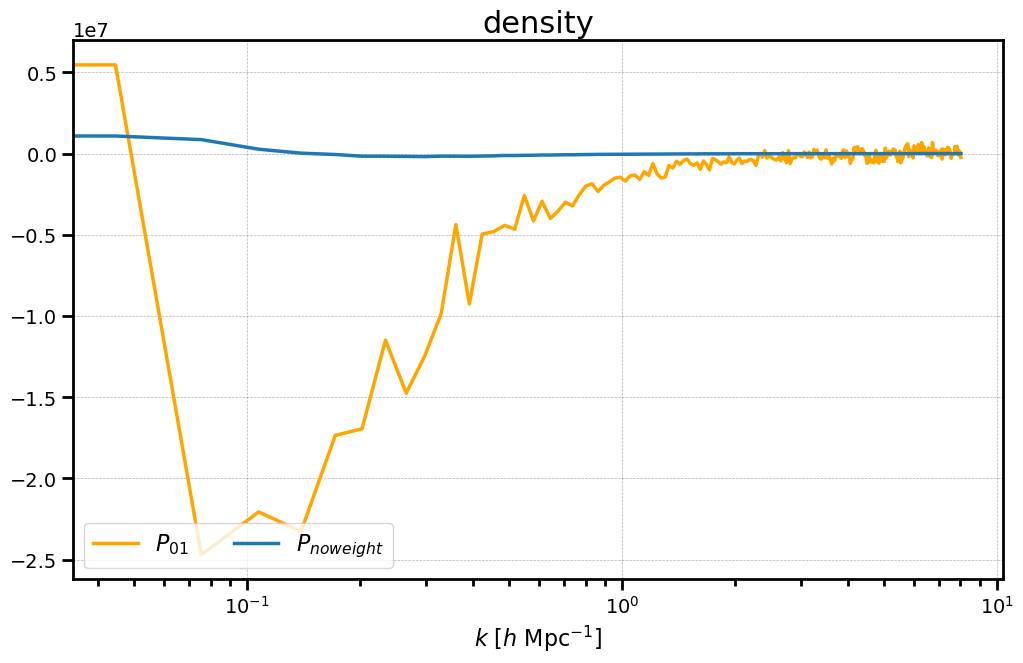

In [68]:
plt.loglog(r01_rw.power['k'], P01_rw, label=r"$P_{01}$", color='orange')
plt.loglog(r01_nw.power['k'], P01_nw, label=r"$P_{noweight}$")
plt.title("density")
plt.legend(loc='lower left', ncol=2)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
# plt.ylabel(r"$P_{xy}$ [$h^{-3} \mathrm{Mpc}^3$]")
# plt.xlim(0.01, 0.6)
plt.yscale('linear')

In [ ]:
a = np.array(cat[:,0])
a.max()